<center>

# **Single-GPU LLM Serving Simulation: Scheduling Trade-offs Between FCFS and Prefill-First**

### ORIE 4580 Final Project Report

Team: Gerardo Andres Pantin, Cristina Casellas, Francesca Azzarito, Alexis Rozen

Date: December 17, 2025

</center>

## **Executive Summary**

In our research project, we have developed a discrete event simulation of a single-GPU Large Language Model (LLM) serving system to determine how the choice of scheduling policy affects the perceived latency of users and overall performance of the system. Our model captures the two stage process for performing LLM inference. The first stage is referred to as a "prefill" and is responsible for processing the input prompt which allows for generation to occur, and the second stage is called a "decode", and generates each output token sequentially. In addition to comparing the two scheduling policies implemented in our notebook, we used our simulator to measure the performance of each policy using four experience-based measures: Time to First Token (TTFT), Time Between Tokens (TBT), Total Latency and Throughput.

We have run multiple experiments using the simulator, and the results are consistent with a trade-off. While Prefill-First significantly improved TTFT (meaning response times began much quicker), it had a negative impact on Total Latency and Streaming Smoothness (Higher TBT), particularly as the load was increased. This can be seen in the results of the "baseline stable" experiment (type A traffic only, $\lambda_A = 0.60$): Prefill-First reduced Mean TTFT from 0.92 to 0.25, but increased Mean Total Latency from 1.72 to 2.57, and increased Mean TBT from 0.05 to 0.14. Throughput remained relatively consistent under both policies at the same load level.

The Load Sweep Experiment ($\lambda_A$ varied from 0.10 to 2.00) further reinforced this trend; Prefill-First maintained low TTFT over a large range of Arrival Rates, however as the load became very heavy, it led to rapid increases in Completion Latency due to Decode Starvation.

From a System Design Perspective, our main Recommendation is to neither choose strictly between First-Come, First-Served (FCFS) nor a Strict Prefill-First Policy, but rather treat them as end points. An implementation ready policy will need to balance the Advantages of Pre-Fill Priority for TTFT, while providing an Explicit Safeguard against Decode Starvation (For example: Token Budgets, Aging, or Minimum Decode Service Guarantees).

## **1. Modeling Approach, Assumptions, and Parameters**

The simulator models a single server processing incoming requests as a function of time. Each request is queued, then scheduled for completion, and each event type (request arrivals, job completions), causes an advancement in the simulation clock. This is a scheduling experiment; the primary purpose of this model is to determine which request(s) to process next at any point during a process given there are many outstanding processes and a number of steps to complete each one.

### **1.1 Request structure: prefill and decode**
In the model, each client request will have two phases; first, it has to go through a "prefill" phase, which has to process the whole prompt before we can generate an output token. Once the prefill phase is done with processing the prompt, the job enters into the "decode" phase, in which it will produce a fixed amount of output tokens at a time. We are able to measure the times for the completion of prefill, the individual completion of each output token, and the final completion of the job by recording timestamps during the simulation. This breakdown is significant, because it models how users interact with the system. Prefill determines when the user sees the system start to respond, and decode determines how long it takes to complete all of the output tokens and how smoothly those output tokens stream out.

### **1.2 Arrival processes**
The arrival of jobs is represented by independent Poisson processes. Alternatively, the interarrival time is an independent exponentially distributed random variable:

$T_{arrival} \sim \text{Exponential}(\lambda)$ where $\lambda$ represents the arrival rate. Type A and Type B independent Poisson arrival streams are supported; this is achieved through sampling of exponential interarrival times. This will support a wide variety of workload mixes while the majority of experiments in the above notebook only use Type-A traffic to be clear.

### **1.3 Service-time assumptions**
To keep the model traceable and allow validation by checking standard queueing results, we modeled service times as exponential random variables:

Prefill service times depend on job type:
* $S_{prefill}^{(A)} \sim \text{Exponential}(\mu_{prefill, A})$
* $S_{prefill}^{(B)} \sim \text{Exponential}(\mu_{prefill, B})$

Decode service is modeled per token:
* $S_{decode, token} \sim \text{Exponential}(\mu_{decode})$

The assumptions above were also translated into code where we sample exponential random variables (with expovariate of the appropriate rate) for each arrival and service event.

This is an abstraction of the system and doesn't capture the other aspects of how GPUs can batch jobs together, how kernels can be fused, memory can become a bottleneck, or how long prompts are scaled, but instead will give us the main queueing and scheduling effects of splitting the work into "prefill before first output" versus "token-by-token generation".

### **1.4 Metrics tracked**
The simulator computes metrics that correspond directly to serving objectives:

1. **Time to First token**: time from arrival until prefill completes (time elapsed until the first token is ready).
   $$TTFT = T_{prefill\ finish} - T_{arrival}$$

2. **Total latency**: time from arrival until all tokens are available in the response.
   $$Latency = T_{completion} - T_{arrival}$$

3. **Time Between Tokens**: average time difference between the two consecutive tokens for every request.
   $$TBT = \frac{1}{B - 1} \sum_{k=2}^{B} (T_k - T_{k-1})$$

4. **Throughput**: total number of finished jobs over the simulation duration, after warm-up.
   $$Throughput = \frac{N_{completed}}{T}$$

These three are used together to demonstrate the amount of trade-off required by a scheduler for balancing responsive, high-quality streaming with overall system-wide performance.

### **1.5 Baseline parameters used in notebook experiments**
A representative baseline comparison in the notebook uses type-A traffic only and sets:

* $\lambda_A = 0.6, \lambda_B = 0$
* $\mu_{prefill, A} = 5.0, \mu_{prefill, B} = 3.0, \mu_{decode} = 20.0$

A second analysis sweeps $\lambda_A$ from 0.1 to 2.0 while holding service rates fixed.

## **2. Technical Description of Our Simulation Model**
We have modeled our simulation as a discrete-event model: at any moment in time, the upcoming event (either an arrival or a completion of service) will determine how the current state evolves, and which upcoming event will be scheduled next. We believe this modeling technique is particularly well-suited for queueing systems, and enables us to capture detailed timelines for each individual request without time-step discretization.

### **2.1 Representation of State and Events**
In addition to tracking the server's state (i.e., idle/busy, with what it is processing), we can use one or more queues depending upon policy. The events that occur during the simulation include Type A and Type B arrival events and service completion events. When an arrival event occurs for either Type A or Type B requests, a job object is created and placed into the appropriate queue(s) based on policy, and the next arrival event for that stream is then scheduled.

When a service completion event occurs, the simulation advances a job through its various phases, including completing prefill, generating a decode token, and re-enqueueing a job for its next decode token based upon the token-level interleaving policy. Once all phases of a job are completed, the request is finalized as "completed."

### **2.2 Scheduling Policies Implemented**
**First-Come-First-Served (FCFS)**: There is only one FIFO (First-In-First-Out) queue. The server chooses the next job to serve after it finishes prefill and continues with decoding until the job is completely done. Non-preemptive scheduling ("finish what you started") provides some level of completion stability, but also causes TTFT (time to finish the job) to increase for new arrivals because the server will continue to decode the current job even though new arrivals have been queued for prefill.

**Prefill-First (prefill priority + token-level decode service)**: There are two queues under Prefill-First: a prefill queue and a decode queue. If there is any prefill work being processed, the server will process prefill work before processing decode work. Decoding is processed one token at a time. Once all decode tokens have been processed, the job is placed back into the decode queue and the server will now process the next job in line. This creates a round robin type of behavior for all decode jobs.

This scheduling policy was developed to improve responsiveness by ensuring that no one job is able to dominate the server and prevent new jobs from accessing the server to complete their prefill.

### **2.3 Warm-Up and Sampling Approach**
The notebook has been configured to discard the initial portion of the jobs that have completed in order to minimize the effects of the initialization bias. The notebook is typically set up to attempt to reach 5000 completed jobs and will discard the first 1000 jobs that complete during this time.

When running the $\lambda_A$ sweep, smaller run sizes have been utilized due to speed issues (warmup = 200, max_completed = 1000).

## **3. Verification and Validation**
The validation process for the event engine and queueing logic in the notebook is also done by testing with a known special case. When the decode length is set to 0 ($B=0$), the requests can be serviced only by prefill services. In this case, the system is reduced to an M/M/1 queue. The notebook tests the simulated average waiting time vs. the theoretical average waiting time $[1/(\mu - \lambda)]$ for multiple arrival rates; and demonstrates close agreement between them.

This verification is important as it provides validation of the simulation when analytical results exist. This increases confidence in the implementation of the events of arrivals, service completions, and time keeping.

## **4. Model Analysis and Results**
### **4.1 Comparison of baseline under a moderate load**
To start we will be comparing FCFS and Prefill-First under a typical medium load for both systems with type-A traffic only ($\lambda_A = 0.60; \lambda_B = 0$), and also with the service parameters $\mu_{prefill,A} = 5.00; \mu_{prefill,B} = 3.00; \mu_{decode} = 20.00$.

The following are reported by the notebook for each of the two models:
* **FCFS:** mean TTFT = 0.9197; mean total latency = 1.7191; mean TBT = 0.0499; throughput = 0.4990
* **Prefill-First:** mean TTFT = 0.2458; mean total latency = 2.5743; mean TBT = 0.1443; throughput = 0.4990

The interpretation of the data is straightforward: The preference for completing requests at the earliest possible time as fast as possible, allows the system to appear to have better responsiveness to users. However, when the service capacity is shifted in favor of supporting all the many requests to prefill as fast as possible, there will likely be less continuous progression of decode work on those requests, which leads to longer times between tokens (i.e., higher TBT), and longer total time required for completions (i.e., higher total latency). At this moderate load level, the completion rates per unit of time for the two systems are very close to one another, so the GPU is being utilized similarly, it is simply the distribution of utilization across the different requests that creates such a large difference in how the user experiences the two systems.

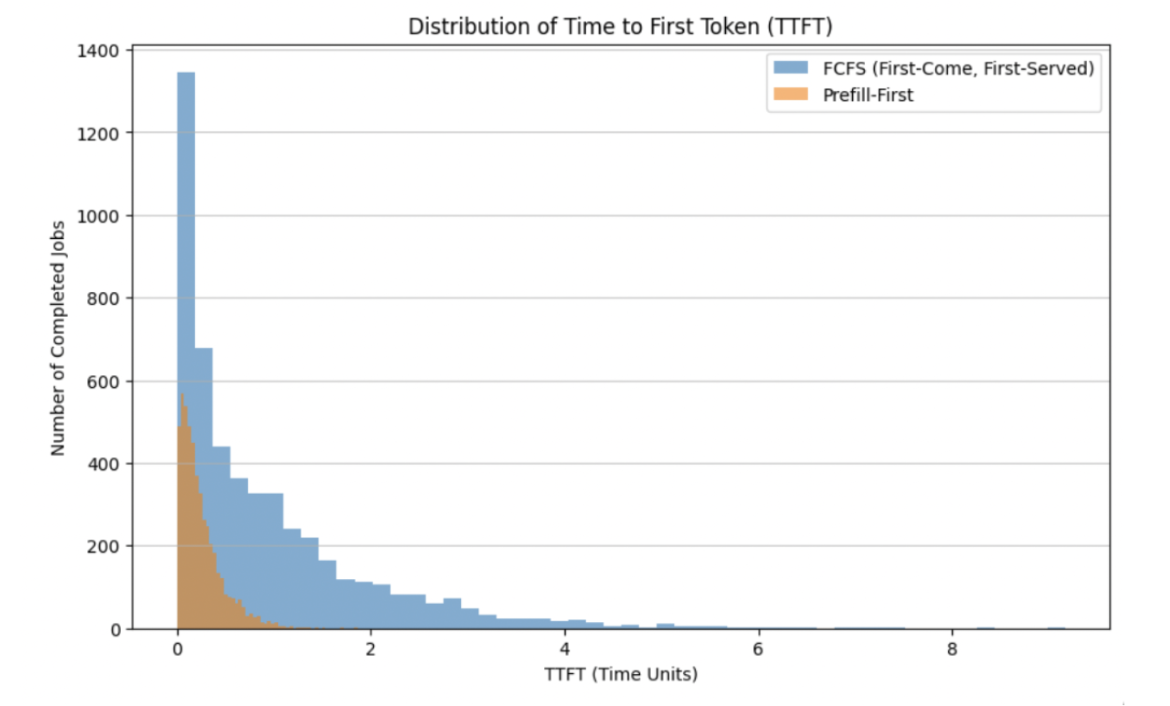

**Figure 1. TTFT vs Number of Completed Jobs**

This graph can be used to show the differences in the distributions of TTFT (not just averages), because responsiveness is often a function of tail-latencies.

### **4.2 Load sweep: stability and saturation behavior**
Next, we will examine how throughput evolves with an increase in demand using a $\lambda_A$ sweep from 0.1 to 2.0 (with type A only).

The notebooks plot throughput, the average TTFT, and average total latency vs. $\lambda_A$ for each policy.

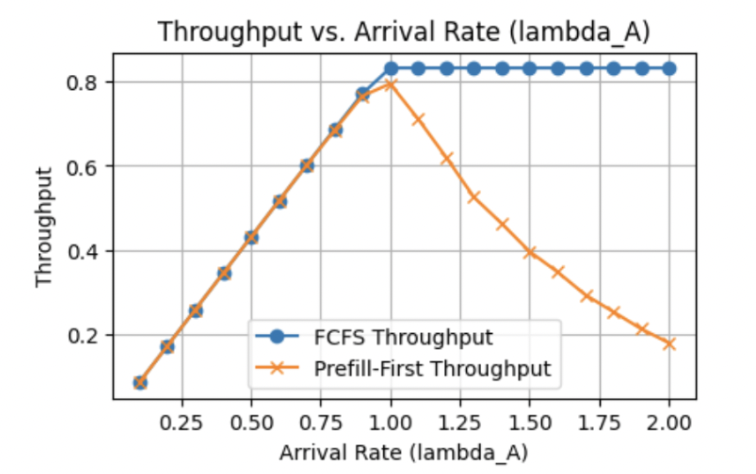
**Figure 2. Throughput vs. $\lambda_A$**

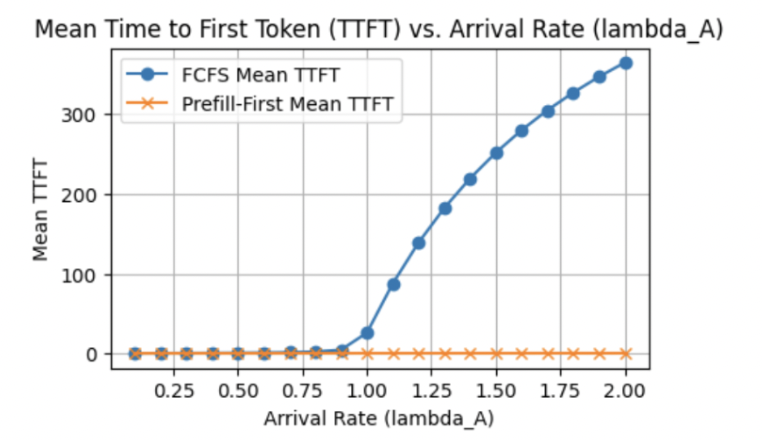
**Figure 3. Mean TTFT vs. $\lambda_A$**

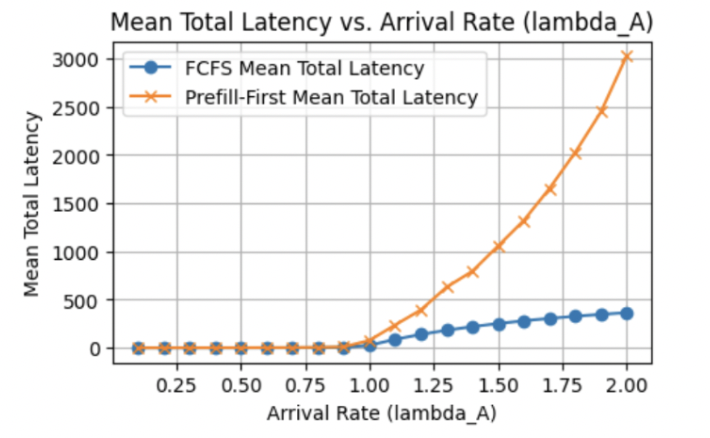
**Figure 4. Mean Total Latency vs. $\lambda_A$**

The sweep in $\lambda_A$ produces the expected results for both policies. Throughput, the average TTFT, and the average total latency are all consistently better for Prefill-First compared to FCFS through a wide variety of loads, as would be expected given that Prefill-First prevents new requests from being blocked from completing prefill by long decode sequences.

At the same time, the average total latency has a very strong trend towards rising quickly as the load gets higher, indicating that decode does not receive enough service when prefill is frequently available. This scenario describes a starving regime: although the system will continue to accept new and prefill work, completion of work will slow down due to the growth of the decode queue.

Overall, the load-sweep analysis was the most significant systems insight generated from this project: in a single-GPU environment, a scheduler's ability to aggressively prioritize prefill over completion can result in improved perceived responsiveness for users, but also can lead to poor completion latencies under high utilization conditions. Therefore, schedulers need to incorporate mechanisms explicitly designed to promote completion fairness if they are going to prioritize TTFT.

## **5. Discussion: Implications for Scheduler Design**
Both of the benchmark policies represent extreme approaches. FCFS protects the completion of tasks by limiting the interruptions once decoding starts, but this approach can lead to poor TTFT when the generation time is large. Prefill-First protects the responsiveness of the system by allowing requests to pass through the prefill phase as quickly as possible. However, this approach can limit the amount of time available to perform decoding when the arrival rate of requests is high.

In terms of designing schedulers for real serving, a hybrid approach would likely offer the best combination of protection for both TTFT and decode progress. Some examples of hybrids that support our conclusions include: enforcing a decode token budget per scheduling cycle, adding aging to the scheduler so that long waiting decode jobs receive higher priority, reserving a fixed percentage of the scheduler's time to allocate to decode when there are backlogs present in the system.

## **6. Conclusion**
This research has shown through the validation of a discrete-event simulator that the choice of scheduling policy in single-GPU LLM serving involves fundamental trade-offs.

As previously stated, prefill-first prioritization can greatly improve TTFT and responsiveness; however, it can result in increased total latency and degraded smoothness of token streaming and may cause decode to be starved at very high loads.

Conversely, FCFS can tend to complete tasks more efficiently once they are started, but it may cause delays to occur before the first token is produced in a task when the decode phases are long.

Our simulator and analyses provide a strong foundation to develop new scheduling policies for production systems that will attempt to balance the objectives of TTFT with completion fairness. The next logical step is to design and compare new hybrid scheduling policies that explicitly prevent starvation of decode while still supporting fast TTFT.

## **Appendix: Technical Appendix**

### **A.1 Reproducibility overview**
The core simulation loop runs until either the maximum number of completions is reached, discards the warm-up portion, and computes the summaries of the remaining completions. In a typical setup, the maximum number of completions is 5000 with 1000 as the warm-up value. Sweep-based experiments use lower values for runtime.

The simulator supports two arrival streams (A and B) with independent exponential interarrivals and uses exponential service times for prefill (type-dependent) and decode (per token).

### **A.2 Job fields and metric computation**
Each job stores arrival time, prefill completion time, completion time, and token completion timestamps. TTFT and total latency are computed as differences in relation to arrival time; TBT is computed from the gap between tokens in the token timestamp list. Warm-up is applied by discarding the first set of completed job IDs.

### **A.3 Implementation-Level Behavior (Policy Mechanisms)**
The First-Come-First-Served policy utilizes one first-in-first-out (FIFO) queue in which a job will continue from where the previous job was left (decode until completed) at the point when that job is finished before starting the next job from the FIFO queue.

In contrast, Prefill-First uses two FIFO queues. It will always serve the jobs in the "prefill" queue if there are jobs present in that queue; otherwise it will serve one job's decode token to complete the decoding process of that job and then place that job back into the second (decode) queue.

### **A.4 Validating Test**
When $B=0$ the system becomes an M/M/1 queue and the notebook compares the simulated mean sojourn time against the theoretically expected mean sojourn time of $1/(\mu - \lambda)$. This comparison is performed using multiple values of $\lambda$ and results show good agreement between the simulations and the theory for all tested values of $\lambda$.

### **A.5 Suggested Replication Strategy for Final Write-Up Quality**
To make the results suitable for inclusion in a report as well as to provide confidence levels for the reported results, multiple independent replications per scenario (policy x $\lambda_A$ x $\lambda_B$ x parameter set) need to be executed, and the mean and 95% confidence interval for TTFT, TBT, total latency, and throughput must be calculated across those replications for the various scenarios. The warm up period and run time must also be documented for each scenario. The notebook currently provides both seeds and repeated calls therefore these additional steps may be easily added on top of the current workflow.